In [242]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob
from scipy.signal import welch, tukey
from scipy.interpolate import interp1d
plt.ion()

## Define fuctions to read the templates and data

In [243]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

In [244]:
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

## Introduce the files and templates

In [245]:
fname='H-H1_LOSC_4_V2-1126259446-32.hdf5'
print('reading file ',fname)
strain,dt,utc=read_file(fname)


template_name='GW150914_4_template.hdf5'
th,tl=read_template(template_name)
print('reading template ',template_name)

reading file  H-H1_LOSC_4_V2-1126259446-32.hdf5
reading template  GW150914_4_template.hdf5


## Plotting the data and template

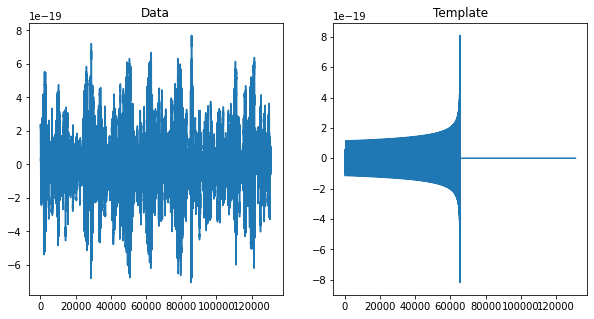

In [246]:
time = np.linspace(1, len(strain), len(strain))
template_time = np.linspace(1, len(th), len(th))

fig, axes= plt.subplots(1,2)
fig.set_size_inches(10,5)
axes[0].plot(time, strain)
axes[0].set_title('Data')

axes[1].plot(template_time, th)
axes[1].set_title('Template')

plt.show()

## Constructing the noise model

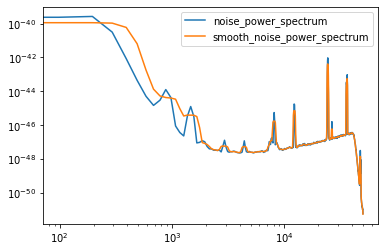

In [247]:
dt= 1e-5
fs = 1/dt
n = 1024

#I choose the tukey window fuction which has this feature of 'flat top'!
freqs, noise_power_spectrum = welch(strain, fs=fs, window=('tukey',len(strain)) , nperseg=n)


n_smooth = 5
smooth_noise_power_spectrum = np.convolve(noise_power_spectrum, np.ones(n_smooth)/n_smooth , mode='same')

plt.figure()
plt.loglog(freqs, noise_power_spectrum, label='noise_power_spectrum')
plt.loglog(freqs, smooth_noise_power_spectrum, label='smooth_noise_power_spectrum')
plt.legend()
plt.show()

In [248]:
#doing the interpolation to adjust the length
noise_spectrum_intp = interp1d(freqs, smooth_noise_power_spectrum, kind='linear')

## Whitening!

In [249]:
def white(time, signal, noise_intp):
  dt = 1e-5
  fs = 1/dt
  spectr = np.fft.rfft(signal*np.hamming(len(signal)))
  freq = np.fft.rfftfreq(len(signal), dt)
  spectr = spectr/np.sqrt(noise_intp(np.abs(freq)))
  whitened_signal = np.fft.irfft(spectr)/np.hamming(len(signal))

  scaling = np.sqrt(np.mean(np.power(signal, 2)))/np.sqrt(np.mean(np.power(whitened_signal, 2)))
  return whitened_signal *scaling, spectr, freq

In [250]:
signal_white, signal_white_spect, freq = white(time, strain, noise_spectrum_intp)
ligo_white, ligo_white_spec, freq= white(time, th, noise_spectrum_intp)

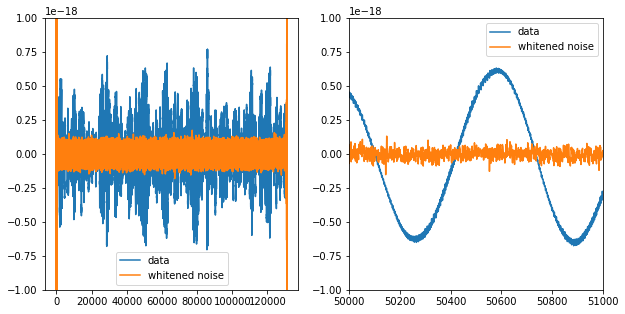

In [251]:
fig, axes= plt.subplots(1,2)
fig.set_size_inches(10,5)
axes[0].plot(time, strain, label='data')
axes[0].plot(time, signal_white, label='whitened noise')
axes[0].set_ylim(-0.1e-17,0.1e-17)
axes[0].legend()

axes[1].plot(time, strain, label='data')
axes[1].plot(time, signal_white, label='whitened noise')
axes[1].set_ylim(-0.1e-17,0.1e-17)
axes[1].set_xlim(5e4,5.1e4)
axes[1].legend()

plt.show()

As you can see, the noised that I have found seems to be whitened very well!

## Ploting the Whitened template

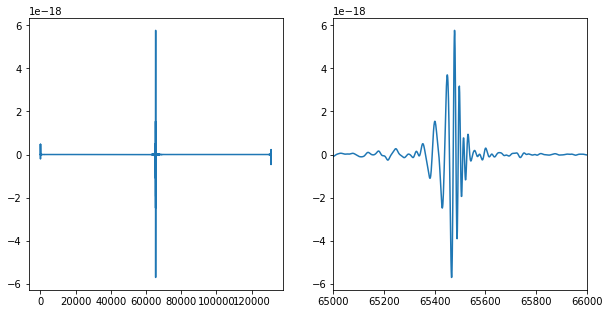

In [252]:
fig, axes= plt.subplots(1,2)
fig.set_size_inches(10,5)
axes[0].plot(template_time, ligo_white)
axes[1].plot(template_time, ligo_white)
axes[1].set_xlim(6.5e4,6.6e4)
plt.show()

In [253]:
ligo_mf_spec = signal_white_spect * ligo_white_spec.conjugate()
ligo_mf = np.fft.irfft(ligo_mf_spec)/np.hamming(len(strain))

In [254]:
np.shape(ligo_mf)

(131072,)

In [255]:
np.shape(time)

(131072,)

In [256]:
max_value = max(th)
for i in range(0, len(th)):
  if th[i]==max_value:
    print('the max index is '+str(i))
    a = i


the max index is 65477


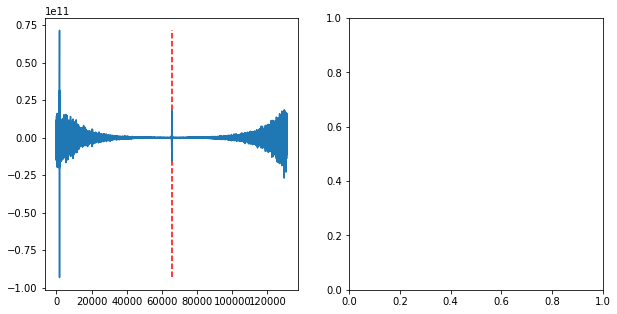

In [257]:
fig, axes= plt.subplots(1,2)
fig.set_size_inches(10,5)

axes[0].plot(time, ligo_mf)

L_min = np.min(ligo_mf)
L_max = np.max(ligo_mf)

axes[0].vlines(a, ymin=L_min, ymax=L_max, color='r', linestyle='--')
plt.show()

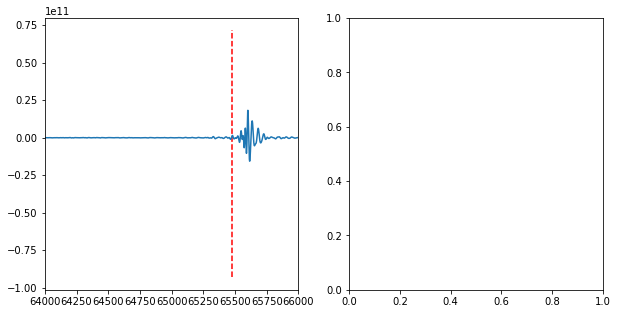

In [258]:
fig, axes= plt.subplots(1,2)
fig.set_size_inches(10,5)

axes[0].plot(time, ligo_mf)

L_min = np.min(ligo_mf)
L_max = np.max(ligo_mf)

axes[0].vlines(a, ymin=L_min, ymax=L_max, color='r', linestyle='--')
axes[0].set_xlim(6.4e4,6.6e4)
plt.show()